# Check pixelated (interpolated) lens potential deflection angles

WARNING - derivatives of the pixelated potential only work properly if the coordinates in the x- and y-directions are identical. Shifting and/or scaling one axis relative to the other gives incorrect lensed images.

In [48]:
# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

# Basic imports
import numpy as np

# Basic JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)

# JAX-ified lenstronomy
from jaxtronomy.Data.pixel_grid import PixelGrid
from jaxtronomy.Data.psf import PSF
from jaxtronomy.LightModel.light_model import LightModel
from jaxtronomy.LensModel.lens_model import LensModel
from jaxtronomy.ImSim.image_model import ImageModel

# Universal font size
FS = 18

### Data grids (image plane and source plane)

In [109]:
npix = 100
pix_scl = 0.08  # arcsec / pixel
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2
transform_pix2angle = pix_scl * np.eye(2)
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}
pixel_grid = PixelGrid(**kwargs_pixel)

# Image plane coordinates
xgrid, ygrid = pixel_grid.pixel_coordinates
x_coords = xgrid[0, :]
y_coords = ygrid[:, 0]
extent = [x_coords[0], x_coords[-1], y_coords[0], y_coords[-1]]

# High-res interpolation
res_factor = 1
x_coords_hd = np.linspace(extent[0], extent[1], res_factor * npix)
y_coords_hd = np.linspace(extent[2], extent[3], res_factor * npix)

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {extent[0], extent[1]} arcsec")
print(f"y range    : {extent[2], extent[3]} arcsec")

image size : (100, 100) pixels
pixel size : 0.08 arcsec
x range    : (-3.96, 3.96) arcsec
y range    : (-3.96, 3.96) arcsec


### Source light model

In [110]:
source_light_model_list = ['SERSIC']
source_light_model = LightModel(source_light_model_list)
kwargs_source_light = [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'center_x': 0.4, 'center_y': 0.15}]

### Analytic lens model (SIE + external shear)

In [111]:
# Analytic lens mass
analytic_lens_mass_model_list = ['SIE', 'SIE', 'SIE', 'SIE', 'SHEAR']
analytic_lens_mass_model = LensModel(analytic_lens_mass_model_list)
analytic_kwargs_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': -1.1, 'center_y': -0.7},
                               {'theta_E': 0.5, 'e1': 0.01, 'e2': -0.2, 'center_x': 1.2, 'center_y': 0.2},
                               {'theta_E': 0.6, 'e1': -0.03, 'e2': 0.8, 'center_x': -0.9, 'center_y': 2.5},
                               {'theta_E': 0.3, 'e1': 0.07, 'e2': -0.4, 'center_x': 2.1, 'center_y': -2.7},
                               {'gamma1': -0.01, 'gamma2': 0.12}]

# Lens light
lens_light_model_list = []
lens_light_model = LightModel(lens_light_model_list)
kwargs_lens_light = [{}]

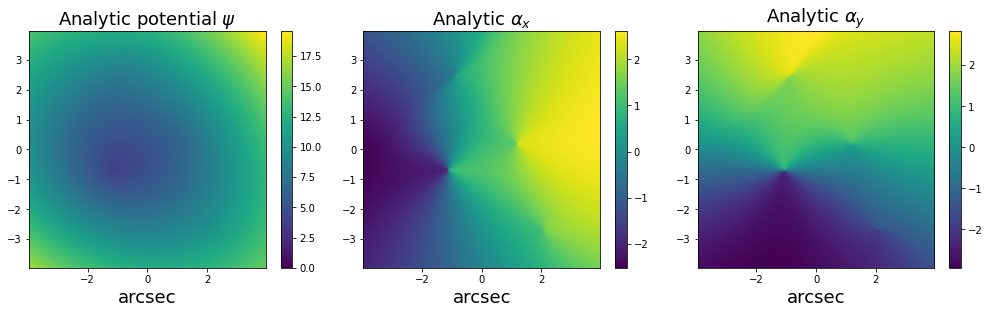

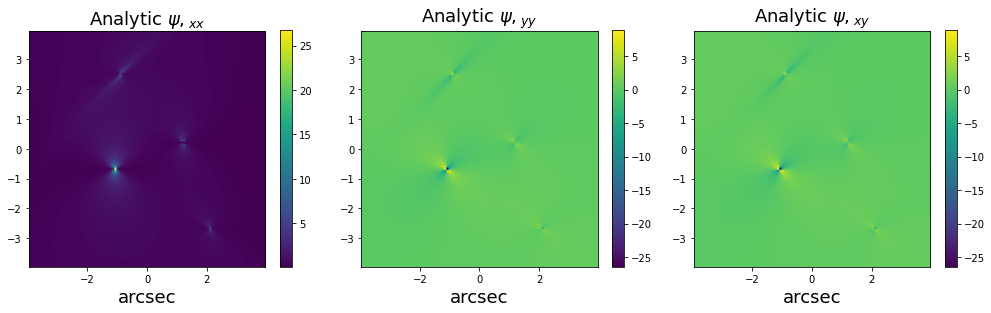

In [112]:
analytic_potential = analytic_lens_mass_model.potential(xgrid, ygrid, analytic_kwargs_lens_mass)
analytic_alpha = analytic_lens_mass_model.alpha(xgrid, ygrid, analytic_kwargs_lens_mass)
analytic_hessian = analytic_lens_mass_model.hessian(xgrid, ygrid, analytic_kwargs_lens_mass)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
img1 = axes[0].imshow(analytic_potential, origin='lower', extent=extent, vmin=0)
axes[0].set_title(r"Analytic potential $\psi$", fontsize=FS)
img2 = axes[1].imshow(analytic_alpha[0], origin='lower', extent=extent)
axes[1].set_title(r"Analytic $\alpha_x$", fontsize=FS)
img3 = axes[2].imshow(analytic_alpha[1], origin='lower', extent=extent)
axes[2].set_title(r"Analytic $\alpha_y$", fontsize=FS)
for img, ax in zip((img1, img2, img3), axes):
    fig.colorbar(img, ax=ax)
    ax.set_xlabel("arcsec", fontsize=FS)
fig.tight_layout()

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
img1 = axes[0].imshow(analytic_hessian[0], origin='lower', extent=extent)
axes[0].set_title(r"Analytic $\psi,_{xx}$", fontsize=FS)
img2 = axes[1].imshow(analytic_hessian[1], origin='lower', extent=extent)
axes[1].set_title(r"Analytic $\psi,_{yy}$", fontsize=FS)
img3 = axes[2].imshow(analytic_hessian[2], origin='lower', extent=extent)
axes[2].set_title(r"Analytic $\psi,_{xy}$", fontsize=FS)
for img, ax in zip((img1, img2, img3), axes):
    fig.colorbar(img, ax=ax)
    ax.set_xlabel("arcsec", fontsize=FS)
fig.tight_layout()

### Pixelated lens model (interpolated from analytic model)

In [113]:
xgrid_hd, ygrid_hd = np.meshgrid(x_coords_hd, y_coords_hd)
analytic_potential_hd = analytic_lens_mass_model.potential(xgrid_hd, ygrid_hd, analytic_kwargs_lens_mass)

# Pixelated lens mass
pixelated_lens_mass_model_list = ['PIXELATED']
pixelated_lens_mass_model = LensModel(pixelated_lens_mass_model_list)
# pixelated_kwargs_lens_mass = [{'x_coords': x_coords, 'y_coords': y_coords, 'psi_grid': analytic_potential}]
pixelated_kwargs_lens_mass = [{'x_coords': x_coords_hd, 'y_coords': y_coords_hd, 'psi_grid': analytic_potential_hd}]

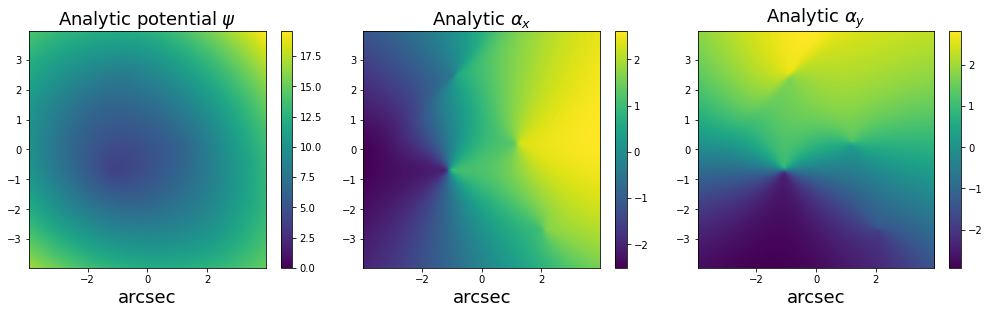

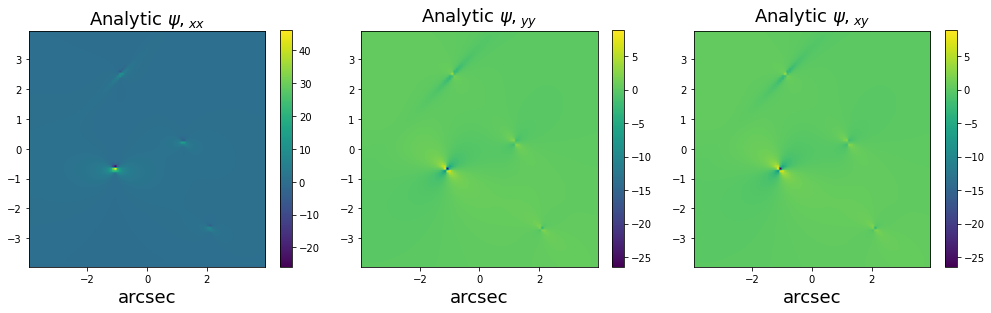

In [114]:
# BEWARE the need to reverse x and y grids !
pixelated_potential = pixelated_lens_mass_model.potential(ygrid, xgrid, pixelated_kwargs_lens_mass)
pixelated_alpha = pixelated_lens_mass_model.alpha(ygrid, xgrid, pixelated_kwargs_lens_mass)
pixelated_hessian = pixelated_lens_mass_model.hessian(ygrid, xgrid, pixelated_kwargs_lens_mass)

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
img1 = axes[0].imshow(pixelated_potential, origin='lower', extent=extent, vmin=0)
axes[0].set_title(r"Analytic potential $\psi$", fontsize=FS)
img2 = axes[1].imshow(pixelated_alpha[0], origin='lower', extent=extent)
axes[1].set_title(r"Analytic $\alpha_x$", fontsize=FS)
img3 = axes[2].imshow(pixelated_alpha[1], origin='lower', extent=extent)
axes[2].set_title(r"Analytic $\alpha_y$", fontsize=FS)
for img, ax in zip((img1, img2, img3), axes):
    fig.colorbar(img, ax=ax)
    ax.set_xlabel("arcsec", fontsize=FS)
fig.tight_layout()

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
img1 = axes[0].imshow(pixelated_hessian[0], origin='lower', extent=extent)
axes[0].set_title(r"Analytic $\psi,_{xx}$", fontsize=FS)
img2 = axes[1].imshow(analytic_hessian[1], origin='lower', extent=extent)
axes[1].set_title(r"Analytic $\psi,_{yy}$", fontsize=FS)
img3 = axes[2].imshow(analytic_hessian[2], origin='lower', extent=extent)
axes[2].set_title(r"Analytic $\psi,_{xy}$", fontsize=FS)
for img, ax in zip((img1, img2, img3), axes):
    fig.colorbar(img, ax=ax)
    ax.set_xlabel("arcsec", fontsize=FS)
fig.tight_layout()

### Residuals

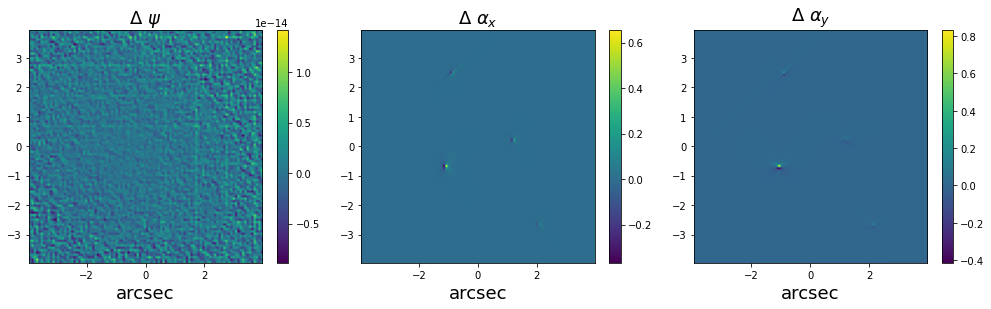

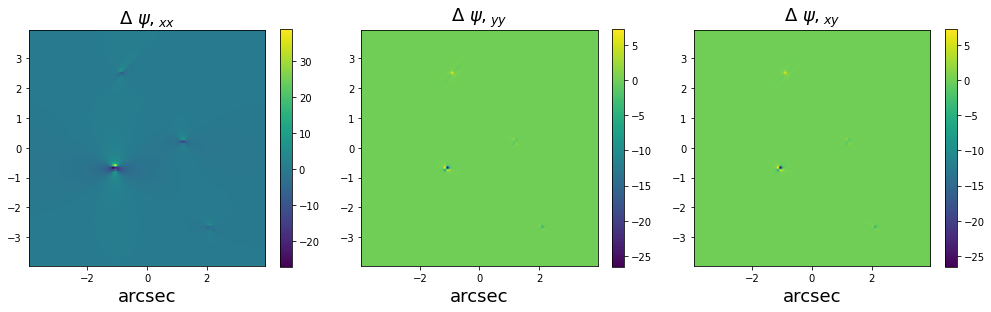

In [115]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
img1 = axes[0].imshow(analytic_potential - pixelated_potential, origin='lower', extent=extent)
axes[0].set_title(r"$\Delta$ $\psi$", fontsize=FS)
img2 = axes[1].imshow(analytic_alpha[0] - pixelated_alpha[0], origin='lower', extent=extent)
axes[1].set_title(r"$\Delta$ $\alpha_x$", fontsize=FS)
img3 = axes[2].imshow(analytic_alpha[1] - pixelated_alpha[1], origin='lower', extent=extent)
axes[2].set_title(r"$\Delta$ $\alpha_y$", fontsize=FS)
for img, ax in zip((img1, img2, img3), axes):
    fig.colorbar(img, ax=ax)
    ax.set_xlabel("arcsec", fontsize=FS)
fig.tight_layout()

fig, axes = plt.subplots(1, 3, figsize=(14, 4))
img1 = axes[0].imshow(analytic_hessian[0] - pixelated_hessian[0], origin='lower', extent=extent)
axes[0].set_title(r"$\Delta$ $\psi,_{xx}$", fontsize=FS)
img2 = axes[1].imshow(analytic_hessian[1] - pixelated_hessian[1], origin='lower', extent=extent)
axes[1].set_title(r"$\Delta$ $\psi,_{yy}$", fontsize=FS)
img3 = axes[2].imshow(analytic_hessian[2] - pixelated_hessian[2], origin='lower', extent=extent)
axes[2].set_title(r"$\Delta$ $\psi,_{xy}$", fontsize=FS)
for img, ax in zip((img1, img2, img3), axes):
    fig.colorbar(img, ax=ax)
    ax.set_xlabel("arcsec", fontsize=FS)
fig.tight_layout()

### PSF

In [116]:
kwargs_psf = {'psf_type': 'NONE', 'fwhm': 0.3}
psf = PSF(**kwargs_psf)

### Image models

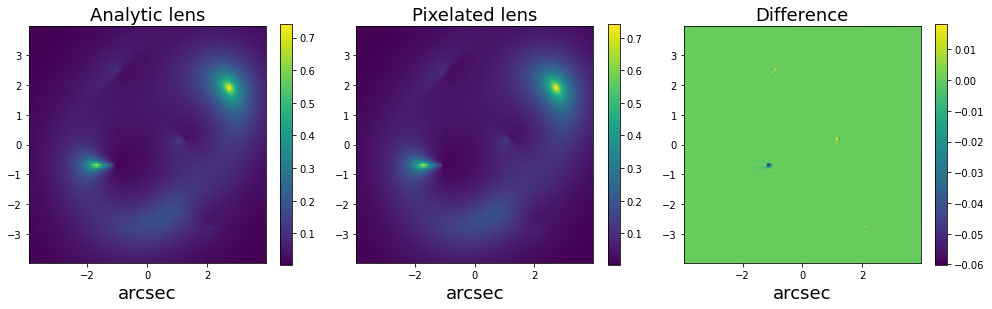

In [117]:
# Generate a lensed image based on PARAMETRIC lens and source models
kwargs_numerics = {'supersampling_factor': 3, 'supersampling_convolution': False}
analytic_image_model = ImageModel(data_class=pixel_grid,
                                    psf_class=psf,
                                    lens_model_class=analytic_lens_mass_model,
                                    source_model_class=source_light_model,
                                    lens_light_model_class=lens_light_model,
                                    point_source_class=None,
                                    kwargs_numerics=kwargs_numerics)

analytic_image = analytic_image_model.image(kwargs_lens=analytic_kwargs_lens_mass,
                                                kwargs_source=kwargs_source_light,
                                                kwargs_lens_light=kwargs_lens_light,
                                                kwargs_ps={})

# Generate a lensed image based on a PIXELATED lens model and a analytic source
pixelated_image_model = ImageModel(data_class=pixel_grid,
                                   psf_class=psf,
                                   lens_model_class=pixelated_lens_mass_model,
                                   source_model_class=source_light_model,
                                   lens_light_model_class=lens_light_model,
                                   point_source_class=None,
                                   kwargs_numerics=kwargs_numerics)

pixelated_image = pixelated_image_model.image(kwargs_lens=pixelated_kwargs_lens_mass,
                                              kwargs_source=kwargs_source_light,
                                              kwargs_lens_light=kwargs_lens_light,
                                              kwargs_ps={})



# Plot
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
img1 = axes[0].imshow(analytic_image, origin='lower', extent=extent)
axes[0].set_title("Analytic lens", fontsize=FS)
img2 = axes[1].imshow(pixelated_image, origin='lower', extent=extent)
axes[1].set_title("Pixelated lens", fontsize=FS)
img3 = axes[2].imshow(analytic_image - pixelated_image, origin='lower', extent=extent)
axes[2].set_title("Difference", fontsize=FS)
for img, ax in zip((img1, img2, img3), axes):
    fig.colorbar(img, ax=ax)
    ax.set_xlabel("arcsec", fontsize=FS)
fig.tight_layout()

In [107]:
%timeit analytic_image_model.image(kwargs_lens=analytic_kwargs_lens_mass, \
                                     kwargs_source=kwargs_source_light, \
                                     kwargs_lens_light=kwargs_lens_light, \
                                     kwargs_ps={})

4.44 ms ± 63.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [108]:
%timeit pixelated_image_model.image(kwargs_lens=pixelated_kwargs_lens_mass, \
                                    kwargs_source=kwargs_source_light, \
                                    kwargs_lens_light=kwargs_lens_light, \
                                    kwargs_ps={})

17.5 ms ± 63.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
